In [1]:
import re
import joblib
import numpy as np 
import pandas as pd 
import seaborn as sns
import matplotlib.pyplot as plt
from xgboost import XGBRegressor
from bidi.algorithm import get_display
from arabic_reshaper import arabic_reshaper
from sklearn.preprocessing import LabelEncoder
from sklearn.metrics import mean_squared_error
from sklearn.ensemble import RandomForestRegressor
from sklearn.model_selection import train_test_split
sns.set(rc={'figure.figsize': [10, 10]}, font_scale=1.3)

C:\ProgramData\Anaconda3\lib\site-packages\scipy\__init__.py:146: UserWarning: A NumPy version >=1.16.5 and <1.23.0 is required for this version of SciPy (detected version 1.26.3
  warnings.warn(f"A NumPy version >={np_minversion} and <{np_maxversion}"


In [2]:
pd.set_option('display.max_columns', None)
df = pd.read_csv(r'H:\cars scraping\cars.csv')

In [3]:
df

,name,price,type,model,color,place,km,images
0,اوبل جراند لاند 2020,1800000.0,اوبل,جراند لاند,فضي,القاهرة,38000.0,NaN
1,جاك JS3 2022,900000.0,جاك,JS3,احمر,القاهرة,45000.0,NaN
2,بيجو 5008 2015,750000.0,بيجو,5008,برونزي,قويسنا,174000.0,NaN
3,كيا سبورتاج 2021,2000000.0,كيا,سبورتاج,أزرق,التجمع - القاهرة الجديدة,90000.0,NaN
4,رينو كابتشر 2016,800000.0,رينو,كابتشر,برتقالى,تقسيط,107000.0,NaN
...,...,...,...,...,...,...,...,...
23005,جيلي امجراند 7 2018,295000.0,جيلي,امجراند 7,فيراني,القاهرة,97000.0,NaN
23006,نيسان صنى 2023,620000.0,نيسان,صنى,احمر,كسر زيرو,2000.0,NaN
23007,شيرى تيجو 7 برو 2022,1100000.0,شيرى,تيجو 7 برو,احمر,6 أكتوبر,27000.0,NaN
23008,بريليانس جالينا 2007,250000.0,بريليانس,جالينا,احمر غامق,أسيوط,181000.0,NaN


In [4]:
df.drop('images', axis=1, inplace=True)

In [5]:
def extract_date(text):
    matches = re.findall(r'\b\d{4}\b', text)  # Find all four consecutive digits representing the year
    valid_dates = [int(match) for match in matches if 1950 < int(match) <= 2024]  # Filter valid dates within the range (1950, 2024]
    
    if valid_dates:  # If there are valid dates found
        return valid_dates[0]  # Return the first valid date
    else:
        name_parts = text.split()  # Split the text into parts
        if len(name_parts) >= 3:
            try:
                return int(name_parts[2])  # Attempt to return the third part as a date
            except ValueError:
                return None  # Return None if the third part is not a valid date
        else:
            return None  # Return None if there is no valid date in the text

# Apply the function to the text column to extract dates
df['year'] = df['name'].apply(extract_date)

In [6]:
df

,name,price,type,model,color,place,km,year
0,اوبل جراند لاند 2020,1800000.0,اوبل,جراند لاند,فضي,القاهرة,38000.0,2020
1,جاك JS3 2022,900000.0,جاك,JS3,احمر,القاهرة,45000.0,2022
2,بيجو 5008 2015,750000.0,بيجو,5008,برونزي,قويسنا,174000.0,2015
3,كيا سبورتاج 2021,2000000.0,كيا,سبورتاج,أزرق,التجمع - القاهرة الجديدة,90000.0,2021
4,رينو كابتشر 2016,800000.0,رينو,كابتشر,برتقالى,تقسيط,107000.0,2016
...,...,...,...,...,...,...,...,...
23005,جيلي امجراند 7 2018,295000.0,جيلي,امجراند 7,فيراني,القاهرة,97000.0,2018
23006,نيسان صنى 2023,620000.0,نيسان,صنى,احمر,كسر زيرو,2000.0,2023
23007,شيرى تيجو 7 برو 2022,1100000.0,شيرى,تيجو 7 برو,احمر,6 أكتوبر,27000.0,2022
23008,بريليانس جالينا 2007,250000.0,بريليانس,جالينا,احمر غامق,أسيوط,181000.0,2007


In [7]:
df.drop("name",axis=1, inplace=True)

In [8]:
# Drop rows with NaN values in any column
df = df.dropna()

# Reset the index after dropping rows
df.reset_index(drop=True, inplace=True)

In [9]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 21758 entries, 0 to 21757
Data columns (total 7 columns):
 #   Column  Non-Null Count  Dtype  
---  ------  --------------  -----  
 0   price   21758 non-null  float64
 1   type    21758 non-null  object 
 2   model   21758 non-null  object 
 3   color   21758 non-null  object 
 4   place   21758 non-null  object 
 5   km      21758 non-null  float64
 6   year    21758 non-null  int64  
dtypes: float64(2), int64(1), object(4)
memory usage: 1.2+ MB


In [10]:
# Convert float column to int
df["price"] = df["price"].astype(int)
df["km"] = df["km"].astype(int)

C:\Users\Ahmed\AppData\Local\Temp\ipykernel_12740\177128619.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df["price"] = df["price"].astype(int)
C:\Users\Ahmed\AppData\Local\Temp\ipykernel_12740\177128619.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df["km"] = df["km"].astype(int)


In [11]:
# Assuming 'df' is your DataFrame
description = df.describe()

# Iterate over each column in the DataFrame
for col in description.columns:
    # Apply the formatting operation to the column
    description[col] = description[col].apply(lambda x: "{:.0f}".format(x))

In [12]:
description

,price,km,year
count,21758,21758,21758
mean,907614,133845,2014
std,2057805,87162,8
min,1111,0,1963
25%,400000,69000,2010
50%,650000,125000,2016
75%,1000000,190000,2020
max,250000000,810000,2024


### in col["year"], mean < median beacause there are lots of small values like '1963','1964','1973' and so on,
### these values pull the mean more towards it.
### There is a large difference between these values and the median, unlike values greater than the median, which have a difference of no more than 8 years.

In [13]:
df[df["year"] < 1980].head(50)

,price,type,model,color,place,km,year
1225,49000,فيات,128,احمر,الدقهلية,200000,1977
1541,140000,مرسيدس,200,ذهبي,البحر الأحمر,200000,1979
1827,45000,فيات,128,أزرق,الهرم,20000,1979
1879,160000,مرسيدس,200,بني,حلوان,100000,1977
2404,630000,بيجو,3008,أخضر,العلمين,145000,1977
2652,85000,فيات,132,احمر,القاهرة,20000,1974
3389,160000,مرسيدس,200,احمر,6 أكتوبر,220000,1979
3781,125000,بي ام دبليو,735,أبيض,القاهرة,200000,1979
3819,65000,فيات,131,احمر,الهرم,199999,1976
3931,120000,مرسيدس,200,برونزي,الدقهلية,200000,1977


### in col ["km"], mean > median beause there lots of big values like "810000", "600000" and so on,
### There is a large difference between these values and the median, unlike values smaller than the median.
### the same thing in col["price"].

In [14]:
def get_largest_values_in_col(col, number_of_values=10):
    # Assuming 'df' is your DataFrame and 'column_name' is the name of the specific column
    top_max_values = df.nlargest(number_of_values, col)

    # Extract the top 50 maximum values from the specified column
    top_max_values_column = top_max_values[col].tolist()

    # Filter the DataFrame to return all rows where the values in the specified column match any of the top 10 maximum values
    rows_for_top_max_values = df[df[col].isin(top_max_values_column)]

    # Sort the resulting DataFrame based on the specified column in descending order
    sorted_rows_for_top_max_values = rows_for_top_max_values.sort_values(by=col, ascending=False)
    
    return sorted_rows_for_top_max_values

In [15]:
get_largest_values_in_col('km', 50)

,price,type,model,color,place,km,year
662,1510000,ام جى,اتش اس,أسود,تقسيط,810000,2022
13804,286000,بى واى دى‬,F3,فضي,مدينه السلام,600000,2017
11301,85000,شانا,V101,احمر,الجيزة,550000,2006
9407,130000,سيات,ابيزا,احمر,مدينة نصر,550000,1993
8508,550000,هيونداي,اكسنت RB,رمادي,مدينة الشيخ زايد,550000,2012
20640,175000,دايو,لانوس,فضي,كفر الدوار,550000,2000
17860,450000,هوندا,سيتى,ذهبي,الإسكندرية,550000,2006
21233,550000,جيب,جراند شيروكي,أخضر,الشروق,537000,1999
11832,615000,ميتسوبيشي,لانسر بومة,أبيض,مدينة نصر,520000,2011
19910,205000,هيونداي,فيرنا,أبيض,القاهرة,508000,2012


In [16]:
get_largest_values_in_col('price', 50)

,price,type,model,color,place,km,year
4444,250000000,بورش,918 سبايدر,أزرق,الزمالك,50000,2015
608,111111111,سيتروين,C5,فيراني,الهرم,31000,2022
10122,17000000,لاند روفر,رنج روفر فوج,أسود,كسر زيرو,1,2024
6606,16250000,مرسيدس,G Class,رمادي,التجمع - القاهرة الجديدة,9000,2022
12017,16000000,بورش,كايين,فضي,كسر زيرو,0,2023
8313,13500000,لاند روفر,رنج روفر سبورت,أسود,مستوردة,0,2023
12056,13000000,لاند روفر,رنج روفر سبورت,أسود,كسر زيرو,1,2023
15793,12600000,مرسيدس,560,أسود,المهندسين,7000,2022
9635,12500000,لاند روفر,رنج روفر سبورت,أسود,كسر زيرو,10,2023
10711,12500000,لاند روفر,رنج روفر سبورت,رمادي,كسر زيرو,0,2023


In [17]:
def classify_prices_levels(result):
    if result <= 500000:
        return 1
    elif result <= 1000000:
        return 2
    else:
        return 3
    
df["price_levels"] = df['price'].apply(classify_prices_levels)

C:\Users\Ahmed\AppData\Local\Temp\ipykernel_12740\2525451962.py:9: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df["price_levels"] = df['price'].apply(classify_prices_levels)


In [18]:
df["price_levels"].value_counts()

2    8458
1    7869
3    5431
Name: price_levels, dtype: int64

In [19]:
def classify_km_levels(result):
    if result <= 100000:
        return 1
    elif result <= 200000:
        return 2
    else:
        return 3
    
df["km_levels"] = df['km'].apply(classify_km_levels)

C:\Users\Ahmed\AppData\Local\Temp\ipykernel_12740\2203628177.py:9: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df["km_levels"] = df['km'].apply(classify_km_levels)


In [20]:
df["km_levels"].value_counts()

2    9073
1    8889
3    3796
Name: km_levels, dtype: int64

In [21]:
def classify_years_levels(result):
    if result <= 2010:
        return 1
    elif result <= 2017:
        return 2
    else:
        return 3
    
df["years_levels"] = df['year'].apply(classify_years_levels)

C:\Users\Ahmed\AppData\Local\Temp\ipykernel_12740\2006877513.py:9: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df["years_levels"] = df['year'].apply(classify_years_levels)


In [22]:
df["years_levels"].value_counts()

3    8686
2    7023
1    6049
Name: years_levels, dtype: int64

In [23]:
df = df[['type', 'model', 'color','place', 'year','years_levels','km','km_levels','price','price_levels']]

In [24]:
df

,type,model,color,place,year,years_levels,km,km_levels,price,price_levels
0,اوبل,جراند لاند,فضي,القاهرة,2020,3,38000,1,1800000,3
1,جاك,JS3,احمر,القاهرة,2022,3,45000,1,900000,2
2,بيجو,5008,برونزي,قويسنا,2015,2,174000,2,750000,2
3,كيا,سبورتاج,أزرق,التجمع - القاهرة الجديدة,2021,3,90000,1,2000000,3
4,رينو,كابتشر,برتقالى,تقسيط,2016,2,107000,2,800000,2
...,...,...,...,...,...,...,...,...,...,...
21753,جيلي,امجراند 7,فيراني,القاهرة,2018,3,97000,1,295000,1
21754,نيسان,صنى,احمر,كسر زيرو,2023,3,2000,1,620000,2
21755,شيرى,تيجو 7 برو,احمر,6 أكتوبر,2022,3,27000,1,1100000,3
21756,بريليانس,جالينا,احمر غامق,أسيوط,2007,1,181000,2,250000,1


In [25]:
new_df = df.copy()

In [26]:
# Reshape Arabic labels
new_df['color'] = new_df['color'].apply(lambda x: get_display(arabic_reshaper.reshape(x)))

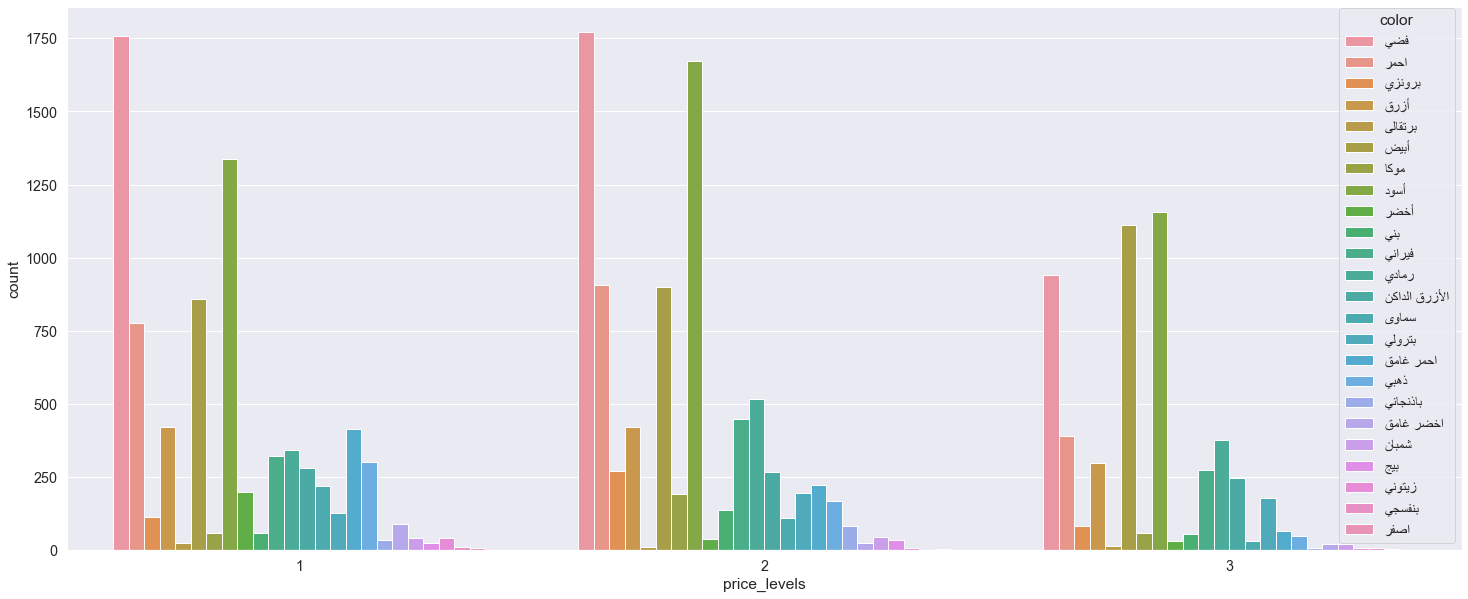

In [27]:
# Plot countplot
plt.figure(figsize=(25, 10))
sns.countplot(data=new_df, x='price_levels', hue='color')

# Rotate x-axis labels for better readability (optional)
plt.xticks(rotation=0)

plt.show()

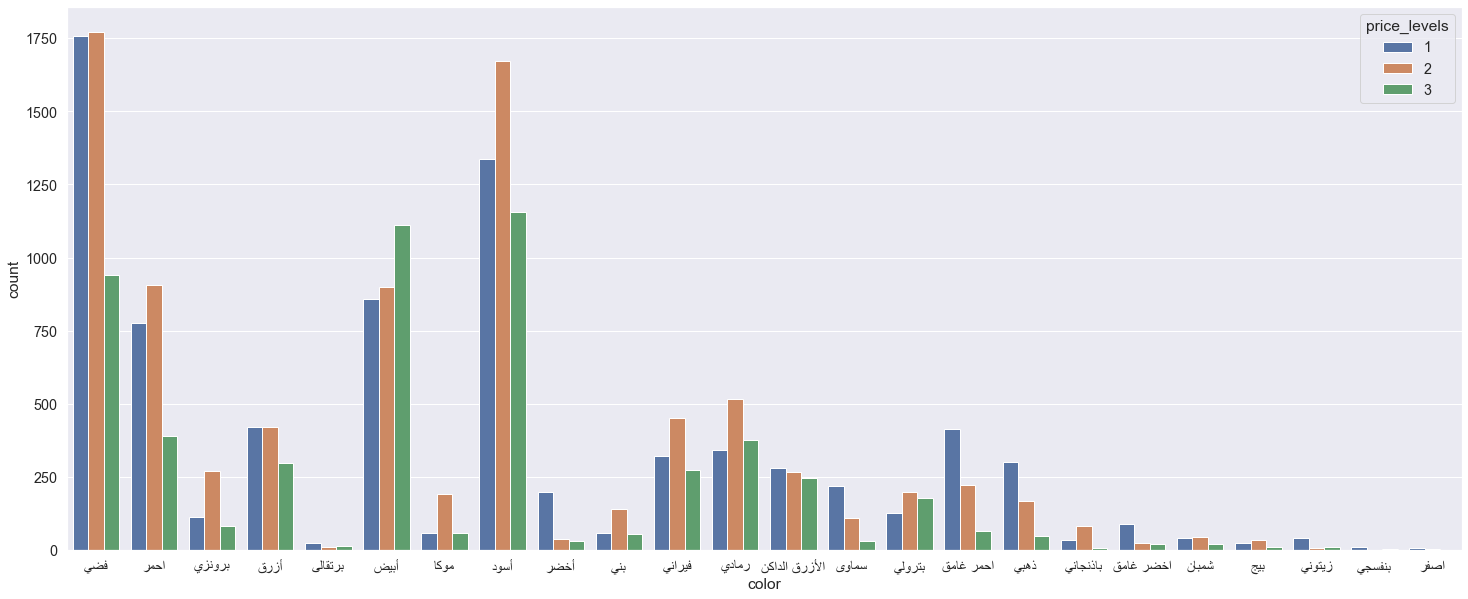

In [28]:
# Plot countplot
plt.figure(figsize=(25, 10))
sns.countplot(data=new_df, x='color', hue='price_levels')

# Rotate x-axis labels for better readability (optional)
plt.xticks(rotation=0)

plt.show()

In [29]:
# Reshape Arabic labels
new_df['year'] = new_df['year'].astype(str).apply(lambda x: get_display(arabic_reshaper.reshape(x)))

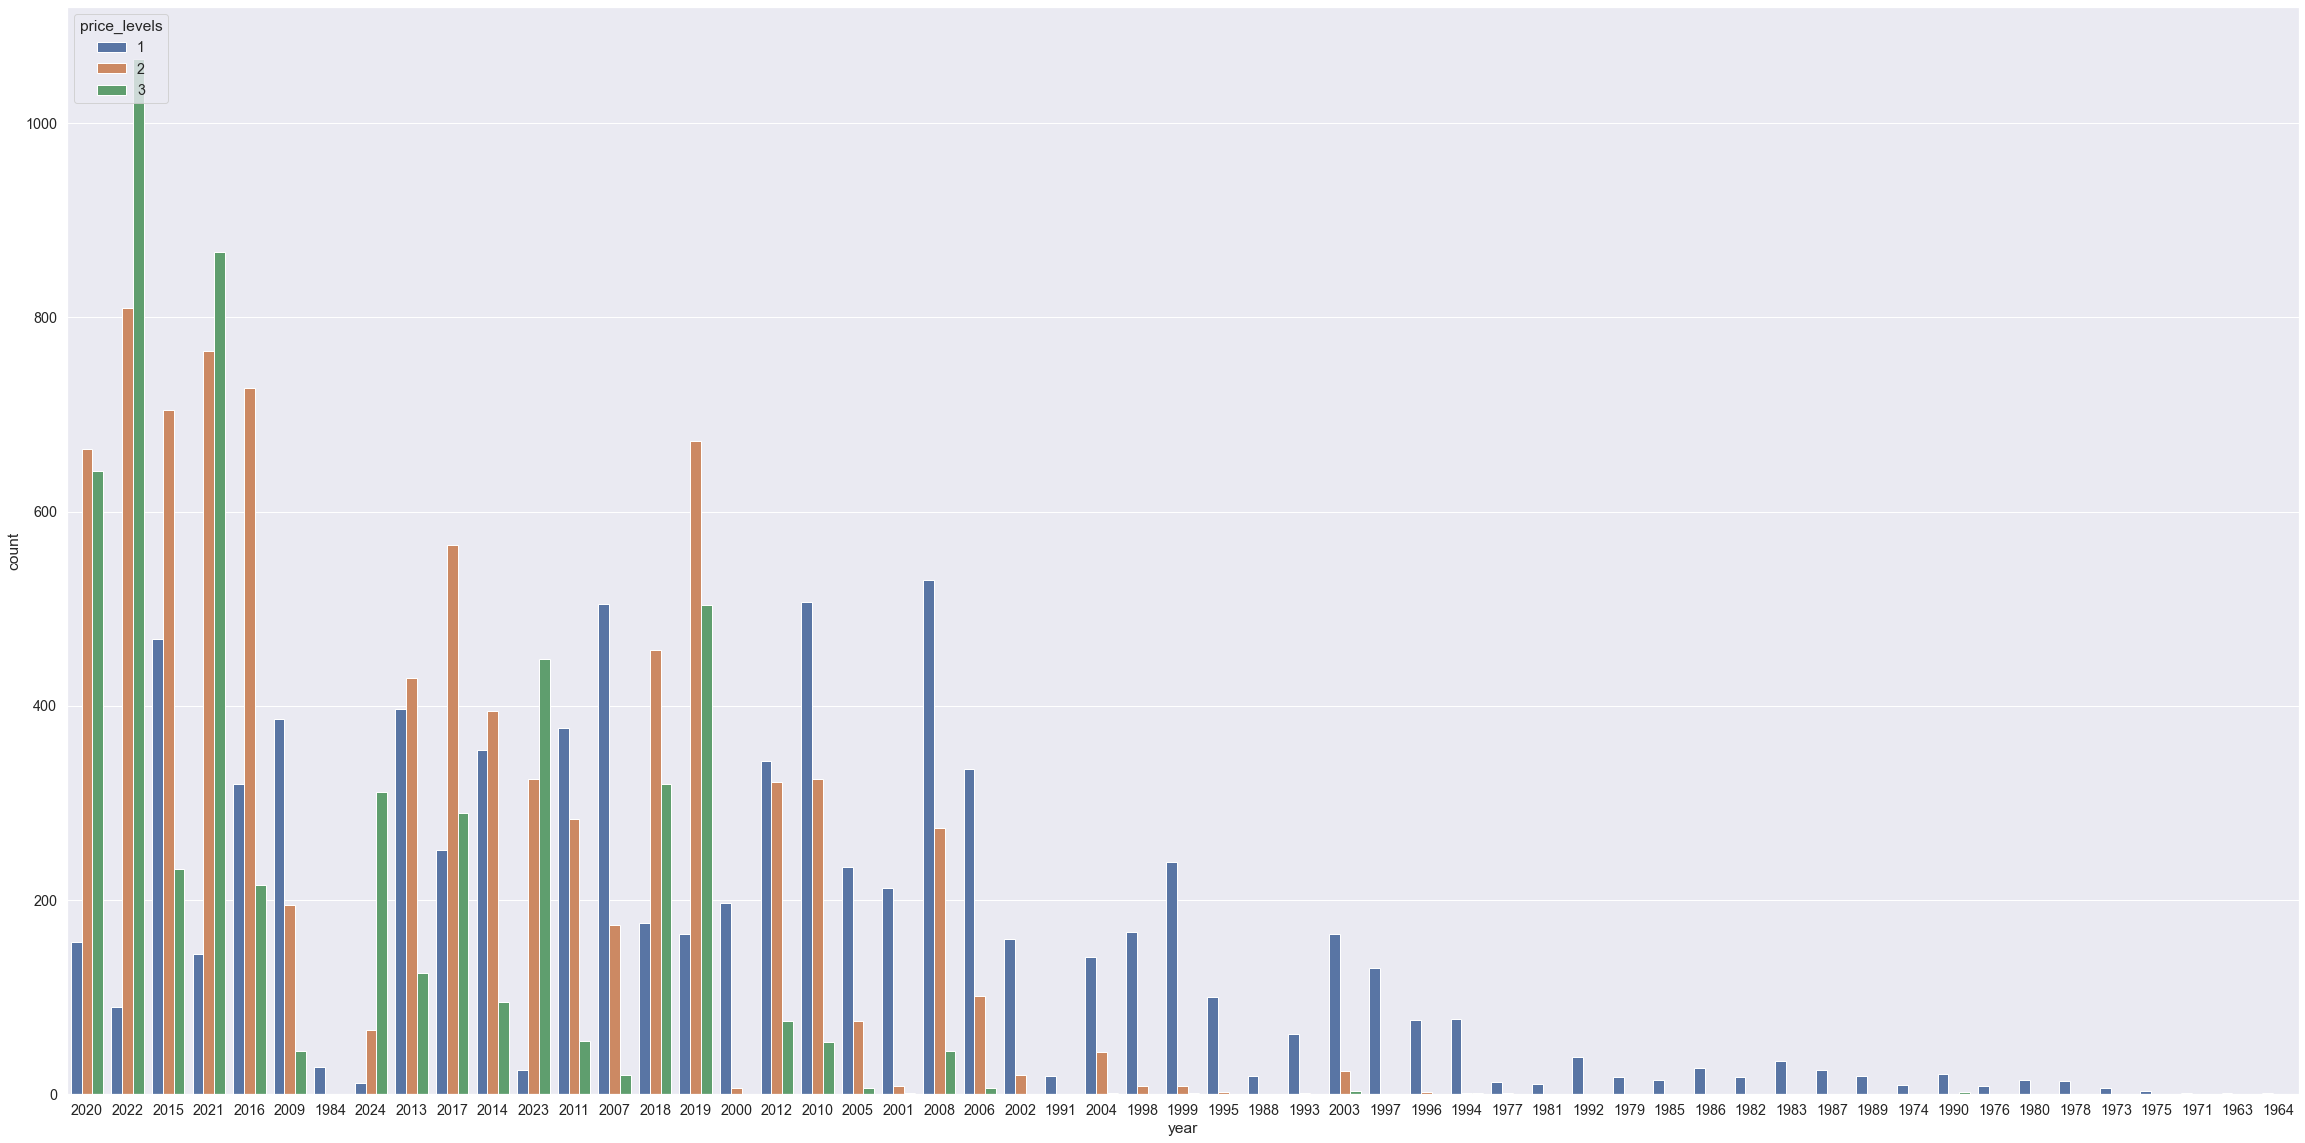

In [30]:
# Plot countplot
plt.figure(figsize=(40, 20))
sns.countplot(data=new_df, hue='price_levels', x='year')

# Rotate x-axis labels for better readability (optional)
plt.xticks(rotation=0)

plt.show()

In [31]:
# Reshape Arabic labels
new_df['km_levels'] = new_df['km_levels'].astype(str).apply(lambda x: get_display(arabic_reshaper.reshape(x)))

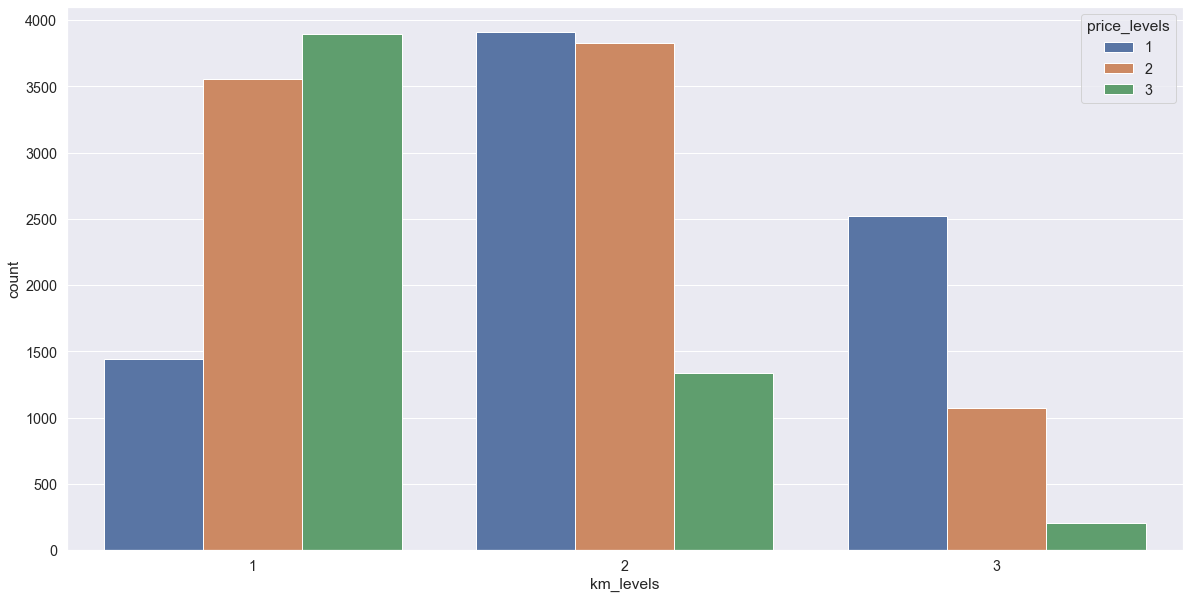

In [32]:
# Plot countplot
plt.figure(figsize=(20, 10))
sns.countplot(data=new_df, hue='price_levels', x='km_levels')

# Rotate x-axis labels for better readability (optional)
plt.xticks(rotation=0)

plt.show()

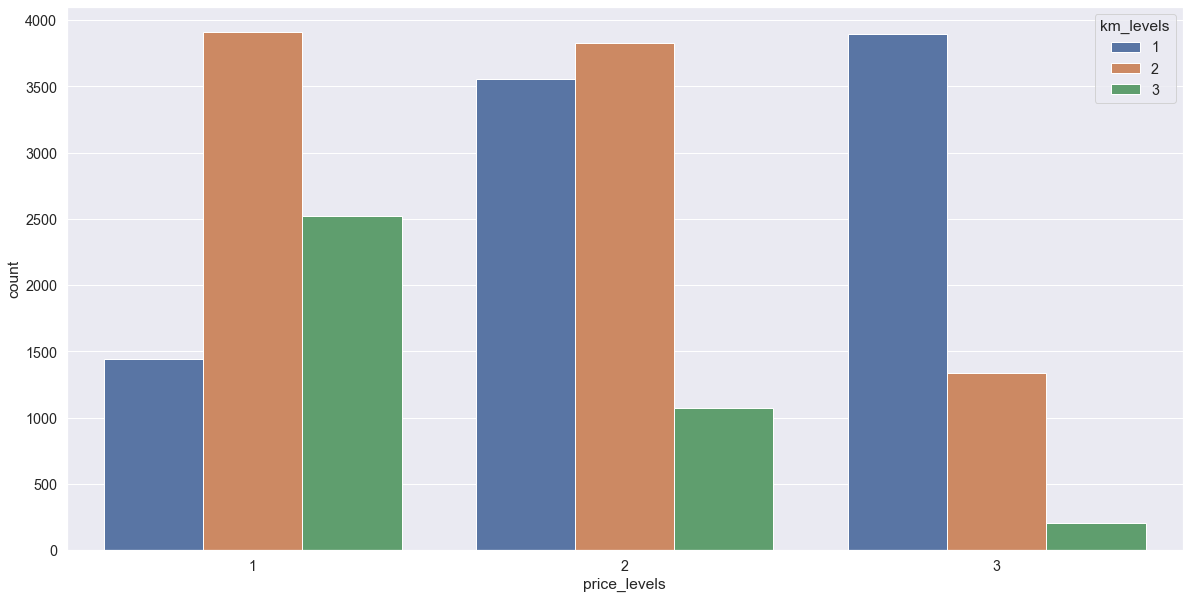

In [33]:
# Plot countplot
plt.figure(figsize=(20, 10))
sns.countplot(data=new_df, x='price_levels', hue='km_levels')

# Rotate x-axis labels for better readability (optional)
plt.xticks(rotation=0)

plt.show()

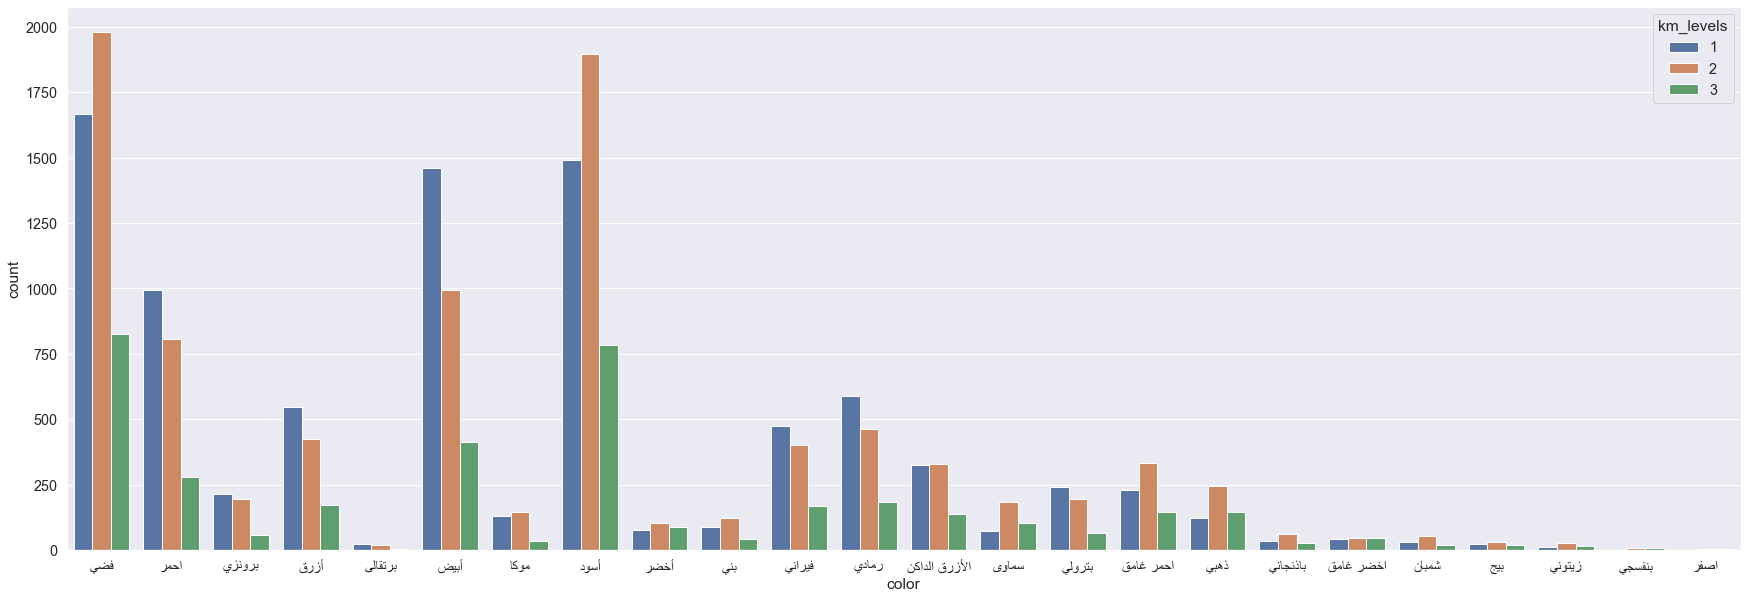

In [34]:
# Plot countplot
plt.figure(figsize=(30, 10))
sns.countplot(data=new_df, x='color', hue='km_levels')

# Rotate x-axis labels for better readability (optional)
plt.xticks(rotation=0)

plt.show()

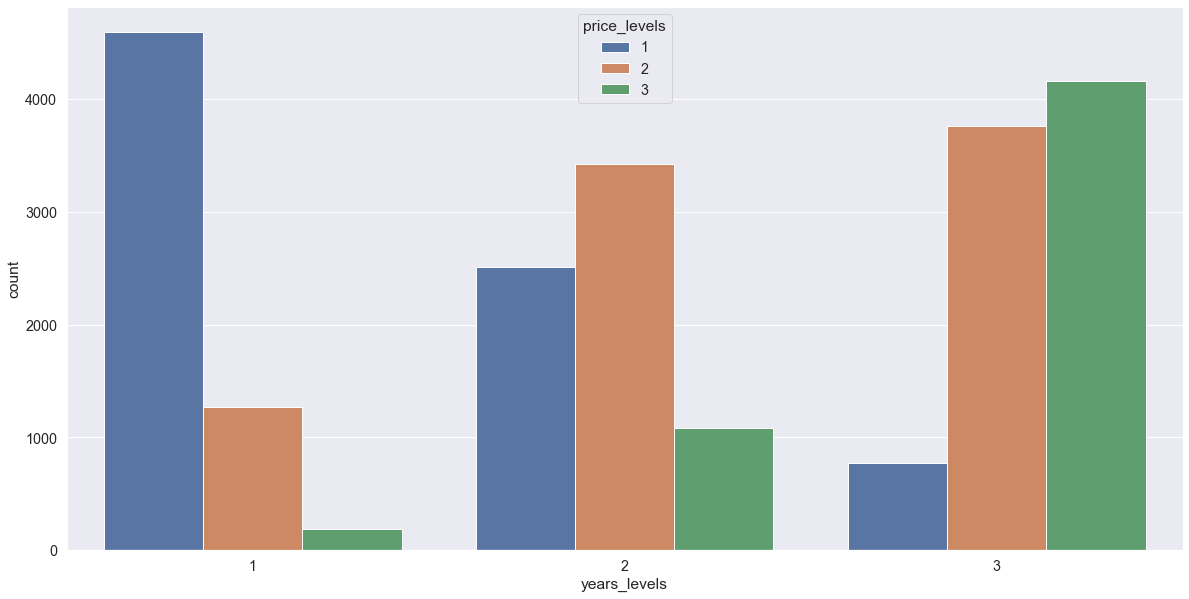

In [35]:
# Plot countplot
plt.figure(figsize=(20, 10))
sns.countplot(data=new_df, x='years_levels', hue='price_levels')

# Rotate x-axis labels for better readability (optional)
plt.xticks(rotation=0)

plt.show()

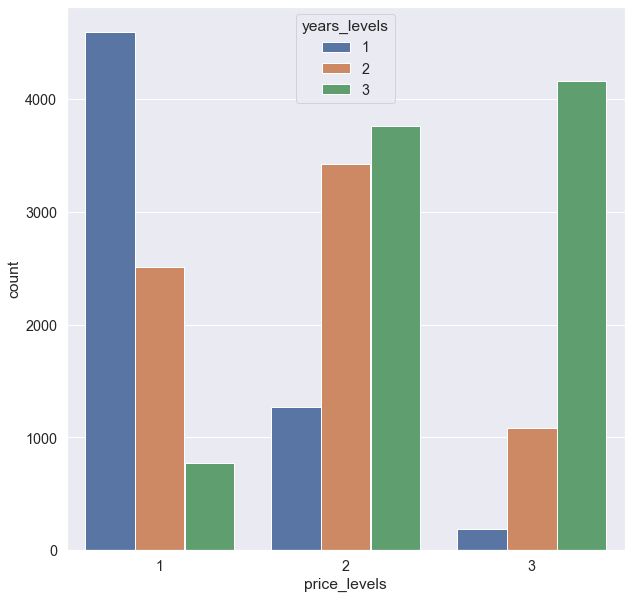

In [36]:
# Plot countplot
plt.figure(figsize=(10, 10))
sns.countplot(data=new_df, hue='years_levels', x='price_levels')

# Rotate x-axis labels for better readability (optional)
plt.xticks(rotation=0)

plt.show()

In [37]:
corr = new_df.corr()
corr

,years_levels,km,price,price_levels
years_levels,1.000000,-0.599318,0.193563,0.590102
km,-0.599318,1.000000,-0.180282,-0.470959
price,0.193563,-0.180282,1.000000,0.308034
price_levels,0.590102,-0.470959,0.308034,1.000000


In [38]:
def apply_label_encoder(col_name):
    # Assuming 'column_name' is the name of the column you want to encode
    unique_values = df[col_name].unique()

    # Create a dictionary mapping unique values to integer labels
    value_to_label = {value: label+1 for label, value in enumerate(unique_values)}

    # Convert the column values to their corresponding integer labels using label encoding
    label_encoder = LabelEncoder()
    df[col_name] = label_encoder.fit_transform(df[col_name]) + 1

    # Optionally, you can also create a reverse mapping from labels to original values
    label_to_value = {label: value for value, label in value_to_label.items()}
    return

In [39]:
apply_label_encoder('color')
apply_label_encoder('model')
apply_label_encoder('type')
apply_label_encoder('place')

In [40]:
df

,type,model,color,place,year,years_levels,km,km_levels,price,price_levels
0,10,569,22,39,2020,3,38000,1,1800000,3
1,28,256,5,39,2022,3,45000,1,900000,2
2,22,82,13,87,2015,2,174000,2,750000,2
3,78,654,3,16,2021,3,90000,1,2000000,3
4,45,746,12,61,2016,2,107000,2,800000,2
...,...,...,...,...,...,...,...,...,...,...
21753,36,435,23,39,2018,3,97000,1,295000,1
21754,94,699,5,89,2023,3,2000,1,620000,2
21755,62,541,5,1,2022,3,27000,1,1100000,3
21756,15,555,6,6,2007,1,181000,2,250000,1


In [41]:
feature_imp = df.corr()['price'].sort_values(ascending = False)
feature_imp

price           1.000000
price_levels    0.308034
years_levels    0.193563
year            0.192764
place           0.048330
type           -0.010758
color          -0.030011
model          -0.090443
km_levels      -0.159920
km             -0.180282
Name: price, dtype: float64

In [42]:
corr = df.corr()
corr

,type,model,color,place,year,years_levels,km,km_levels,price,price_levels
type,1.000000,0.201457,0.062429,0.030850,-0.018477,-0.034931,0.005099,0.007788,-0.010758,0.000343
model,0.201457,1.000000,0.044910,-0.024332,-0.050716,-0.123410,0.111988,0.115747,-0.090443,-0.155627
color,0.062429,0.044910,1.000000,-0.001307,0.006593,-0.037924,0.031715,0.041128,-0.030011,-0.055295
place,0.030850,-0.024332,-0.001307,1.000000,0.078724,0.072835,-0.102793,-0.082617,0.048330,0.090050
year,-0.018477,-0.050716,0.006593,0.078724,1.000000,0.860659,-0.546419,-0.492013,0.192764,0.582443
years_levels,-0.034931,-0.123410,-0.037924,0.072835,0.860659,1.000000,-0.599318,-0.572643,0.193563,0.590102
km,0.005099,0.111988,0.031715,-0.102793,-0.546419,-0.599318,1.000000,0.899247,-0.180282,-0.470959
km_levels,0.007788,0.115747,0.041128,-0.082617,-0.492013,-0.572643,0.899247,1.000000,-0.159920,-0.436070
price,-0.010758,-0.090443,-0.030011,0.048330,0.192764,0.193563,-0.180282,-0.159920,1.000000,0.308034
price_levels,0.000343,-0.155627,-0.055295,0.090050,0.582443,0.590102,-0.470959,-0.436070,0.308034,1.000000


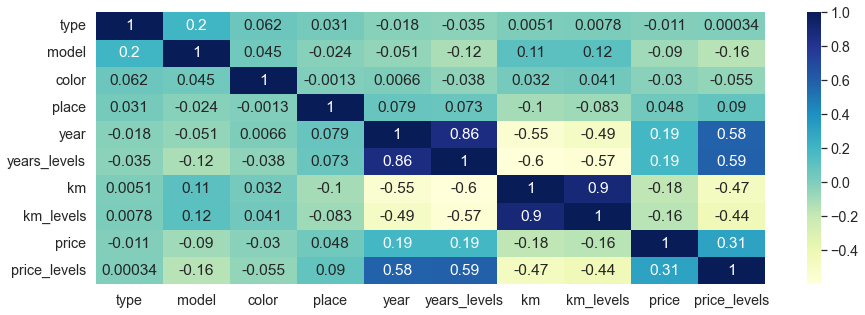

In [47]:
plt.figure(figsize = (15, 5))
sns.heatmap(data=corr, annot=True, cmap="YlGnBu")
plt.show()

In [48]:
columns = ['price_levels']
df.drop(columns=columns, axis=1, inplace=True)

In [49]:
X = df.drop('price', axis=1)
y = df['price']

In [50]:
from sklearn.metrics import mean_absolute_error

In [51]:
# Split the data into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

In [52]:
# Instantiate the XGBoost regressor
xgb_regressor = XGBRegressor(objective='reg:squarederror', random_state=42)

# Train the model
xgb_regressor.fit(X_train, y_train)

# Make predictions
y_pred = xgb_regressor.predict(X_test)

# Assuming 'y_true' contains the true target values and 'y_pred' contains the predicted values
mae = mean_absolute_error(y_test, y_pred)

print('Mean Absolute Error:', round(mae))

Mean Absolute Error: 198742


In [53]:
# Instantiate the Random Forest regressor
rf_regressor = RandomForestRegressor(n_estimators=100, random_state=42)

# Train the model
rf_regressor.fit(X_train, y_train)

# Make predictions
y_pred = rf_regressor.predict(X_test)

# Assuming 'y_true' contains the true target values and 'y_pred' contains the predicted values
mae = mean_absolute_error(y_test, y_pred)

print('Mean Absolute Error:', round(mae))

Mean Absolute Error: 184087


In [246]:
# Instantiate the Random Forest regressor
rf_regressor = RandomForestRegressor(n_estimators=100, random_state=42)

# Train the model
rf_regressor.fit(X_train, y_train)

# Make predictions
y_pred = rf_regressor.predict(X_test)

# Assuming 'y_true' contains the true target values and 'y_pred' contains the predicted values
mae = mean_absolute_error(y_test, y_pred)

print('Mean Absolute Error:', round(mae))

Mean Absolute Error: 146331


In [54]:
# Assuming 'y_true' contains the true target values and 'y_pred' contains the predicted values
data = {'True': y_test, 'Predicted': y_pred}
df_y = pd.DataFrame(data)

In [55]:
df_y

,True,Predicted
9755,650000,7.254500e+05
4068,1375000,1.210800e+06
9859,200000,2.374100e+05
20009,650000,7.541000e+05
7656,975000,8.554000e+05
...,...,...
1579,515000,4.897500e+05
2968,350000,3.272000e+05
8530,550000,5.163533e+05
7698,850000,5.389100e+05


In [56]:
# Assuming 'df' is your DataFrame and 'col_name' is the name of the column you want to convert
df_y['Predicted'] = df_y['Predicted'].apply(lambda x: "{:.0f}".format(x))

In [57]:
df_y.head(50)

,True,Predicted
9755,650000,725450
4068,1375000,1210800
9859,200000,237410
20009,650000,754100
7656,975000,855400
13914,800000,834450
10279,630000,444900
18702,900000,893850
1412,850000,833500
14442,1100000,1194300
